In [1]:
!pip install contractions
!pip install datasets
!pip install pytorch_lightning
!pip install transformers

import tensorflow as tf
import torch

from keras.preprocessing import sequence
from keras.models import Sequential
from keras.layers import Dense, Dropout, Embedding, LSTM, Bidirectional

import pandas as pd
import numpy as np
import re
import string
import math
import contractions
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
nltk.download("stopwords")
nltk.download("wordnet")

stop_words = set(stopwords.words('english'))
lemmatizer = WordNetLemmatizer()

import pandas as pd
import numpy as np

from tqdm.auto import tqdm

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader

from transformers import BertTokenizerFast as BertTokenizer, BertModel, AdamW, get_linear_schedule_with_warmup

import pytorch_lightning as pl
from torchmetrics.functional import accuracy, f1_score, auroc
from pytorch_lightning.callbacks import ModelCheckpoint, EarlyStopping
from pytorch_lightning.loggers import TensorBoardLogger

from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, multilabel_confusion_matrix

from pylab import rcParams
from matplotlib import rc
import seaborn as sns
import matplotlib.pyplot as plt
import os



%matplotlib inline
%config InlineBackend.figure_format='retina'

     |████████████████████████████████| 287 kB 30.4 MB/s 
     |████████████████████████████████| 106 kB 69.9 MB/s 
     |████████████████████████████████| 325 kB 16.7 MB/s 
     |████████████████████████████████| 136 kB 55.5 MB/s 
     |████████████████████████████████| 1.1 MB 44.2 MB/s 
     |████████████████████████████████| 77 kB 7.1 MB/s 
     |████████████████████████████████| 212 kB 60.9 MB/s 
     |████████████████████████████████| 127 kB 57.4 MB/s 
     |████████████████████████████████| 94 kB 3.4 MB/s 
     |████████████████████████████████| 271 kB 24.9 MB/s 
     |████████████████████████████████| 144 kB 63.4 MB/s 
  Attempting uninstall: urllib3
    Found existing installation: urllib3 1.24.3
    Uninstalling urllib3-1.24.3:
      Successfully uninstalled urllib3-1.24.3
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
datascience 0.10.6 requires foli

In [2]:
def preprocess(text):
  text= text. replace("\n"," ")
  text=contractions.fix(text) # expanding the contractions
  text=text.lower() # lowering the text
  text=re.sub(r'[^\w\s]', '', text) # removing the punctuation
  text=''.join([i for i in text if not i.isdigit()]) # removing the digits and words containing the digits
  text=" ".join([word for word in str(text).split() if word not in stop_words]) # removing the stopwords
  text=" ".join([lemmatizer.lemmatize(word) for word in text.split()]) # lemmatizing the words

  return text



In [3]:
a="You should know women's \n sports are a joke"


In [4]:
print(preprocess(a))

know woman sport joke


In [5]:
# !pip install datasets

In [6]:
# from datasets import load_dataset

# dataset = load_dataset("ethos", "multilabel")

In [7]:
# dataset


In [8]:
# df=pd.DataFrame(data=dataset)
# df1=[]
# for i in df['train']:
#     df1.append(i)

# df=pd.DataFrame(df1)
# df

In [9]:
from google.colab import drive
drive.mount("/content/gdrive")

Mounted at /content/gdrive


In [10]:
df=pd.read_csv('/content/gdrive/MyDrive/train.csv')

In [11]:
# df=df.drop(['Unnamed: 0'],axis=1)

In [12]:
df

,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,0000997932d777bf,Explanation\nWhy the edits made under my usern...,0,0,0,0,0,0
1,000103f0d9cfb60f,D'aww! He matches this background colour I'm s...,0,0,0,0,0,0
2,000113f07ec002fd,"Hey man, I'm really not trying to edit war. It...",0,0,0,0,0,0
3,0001b41b1c6bb37e,"""\nMore\nI can't make any real suggestions on ...",0,0,0,0,0,0
4,0001d958c54c6e35,"You, sir, are my hero. Any chance you remember...",0,0,0,0,0,0
...,...,...,...,...,...,...,...,...
159566,ffe987279560d7ff,""":::::And for the second time of asking, when ...",0,0,0,0,0,0
159567,ffea4adeee384e90,You should be ashamed of yourself \n\nThat is ...,0,0,0,0,0,0
159568,ffee36eab5c267c9,"Spitzer \n\nUmm, theres no actual article for ...",0,0,0,0,0,0
159569,fff125370e4aaaf3,And it looks like it was actually you who put ...,0,0,0,0,0,0


In [13]:
# df['comment_text']=df['comment_text'].apply(lambda x: preprocess(x))
# df

In [14]:
df=df.drop('id',axis=1)
df

,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,Explanation\nWhy the edits made under my usern...,0,0,0,0,0,0
1,D'aww! He matches this background colour I'm s...,0,0,0,0,0,0
2,"Hey man, I'm really not trying to edit war. It...",0,0,0,0,0,0
3,"""\nMore\nI can't make any real suggestions on ...",0,0,0,0,0,0
4,"You, sir, are my hero. Any chance you remember...",0,0,0,0,0,0
...,...,...,...,...,...,...,...
159566,""":::::And for the second time of asking, when ...",0,0,0,0,0,0
159567,You should be ashamed of yourself \n\nThat is ...,0,0,0,0,0,0
159568,"Spitzer \n\nUmm, theres no actual article for ...",0,0,0,0,0,0
159569,And it looks like it was actually you who put ...,0,0,0,0,0,0


In [15]:
df=df.rename(columns=({'comment_text':"text"}))
df

,text,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,Explanation\nWhy the edits made under my usern...,0,0,0,0,0,0
1,D'aww! He matches this background colour I'm s...,0,0,0,0,0,0
2,"Hey man, I'm really not trying to edit war. It...",0,0,0,0,0,0
3,"""\nMore\nI can't make any real suggestions on ...",0,0,0,0,0,0
4,"You, sir, are my hero. Any chance you remember...",0,0,0,0,0,0
...,...,...,...,...,...,...,...
159566,""":::::And for the second time of asking, when ...",0,0,0,0,0,0
159567,You should be ashamed of yourself \n\nThat is ...,0,0,0,0,0,0
159568,"Spitzer \n\nUmm, theres no actual article for ...",0,0,0,0,0,0
159569,And it looks like it was actually you who put ...,0,0,0,0,0,0


In [16]:
target_columns = list(df.columns.drop(['text']))
target_columns

['toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate']

In [17]:
df[target_columns].sum()

toxic            15294
severe_toxic      1595
obscene           8449
threat             478
insult            7877
identity_hate     1405
dtype: int64

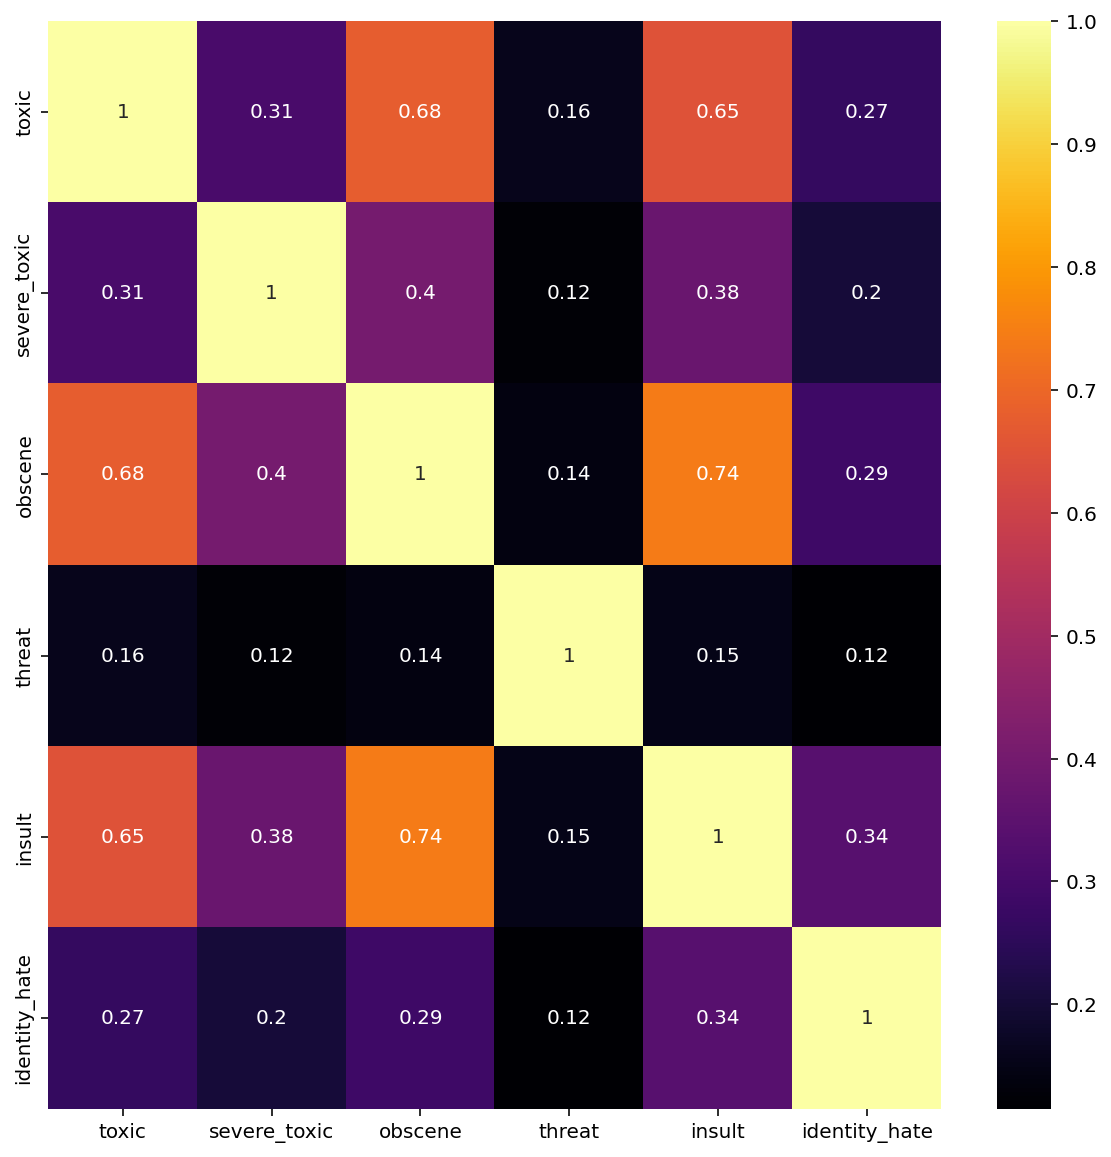

In [18]:
# Visualise any correlations between labels:
# It seems there are some strong correlations between labels
heatmap_data = df[target_columns]
plt.figure(figsize=(10, 10))
ax = sns.heatmap(heatmap_data.corr(), cmap='inferno', annot=True)
ax.tick_params(labelsize=10)

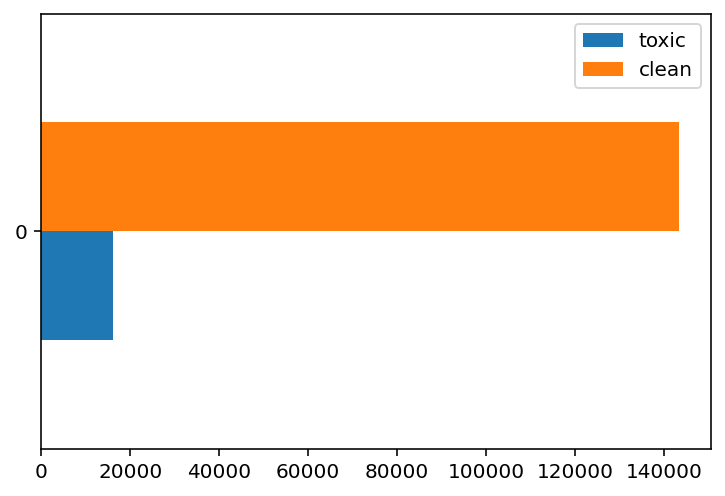

In [19]:
LABEL_COLUMNS = df.columns.tolist()[1:]
df_toxic = df[df[LABEL_COLUMNS].sum(axis=1) > 0]
df_clean = df[df[LABEL_COLUMNS].sum(axis=1) == 0]

pd.DataFrame(dict(
  toxic=[len(df_toxic)], 
  clean=[len(df_clean)]
)).plot(kind='barh');

In [20]:
df_clean

,text,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,Explanation\nWhy the edits made under my usern...,0,0,0,0,0,0
1,D'aww! He matches this background colour I'm s...,0,0,0,0,0,0
2,"Hey man, I'm really not trying to edit war. It...",0,0,0,0,0,0
3,"""\nMore\nI can't make any real suggestions on ...",0,0,0,0,0,0
4,"You, sir, are my hero. Any chance you remember...",0,0,0,0,0,0
...,...,...,...,...,...,...,...
159566,""":::::And for the second time of asking, when ...",0,0,0,0,0,0
159567,You should be ashamed of yourself \n\nThat is ...,0,0,0,0,0,0
159568,"Spitzer \n\nUmm, theres no actual article for ...",0,0,0,0,0,0
159569,And it looks like it was actually you who put ...,0,0,0,0,0,0


In [21]:
df_clean=df_clean[:8000]

In [22]:
df_clean

,text,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,Explanation\nWhy the edits made under my usern...,0,0,0,0,0,0
1,D'aww! He matches this background colour I'm s...,0,0,0,0,0,0
2,"Hey man, I'm really not trying to edit war. It...",0,0,0,0,0,0
3,"""\nMore\nI can't make any real suggestions on ...",0,0,0,0,0,0
4,"You, sir, are my hero. Any chance you remember...",0,0,0,0,0,0
...,...,...,...,...,...,...,...
8929,"""\nThis isn't """"based off of"""" a Cure song. So...",0,0,0,0,0,0
8930,and the largest - the 1996 swing was smaller t...,0,0,0,0,0,0
8931,November 2008 \n\nThank you for experimenting ...,0,0,0,0,0,0
8932,"Many thanks, Jack. So soothing and refreshing!",0,0,0,0,0,0


In [23]:
df_toxic=df_toxic[:8000]

In [24]:
# df=pd.concat([df, df_clean, df_clean]).drop_duplicates(keep=False)

In [25]:
df = df_toxic.append(df_clean, ignore_index=True)

In [26]:
# df['text']=df['text'].apply(lambda x: preprocess(x))
df

,text,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,COCKSUCKER BEFORE YOU PISS AROUND ON MY WORK,1,1,1,0,1,0
1,Hey... what is it..\n@ | talk .\nWhat is it......,1,0,0,0,0,0
2,"Bye! \n\nDon't look, come or think of comming ...",1,0,0,0,0,0
3,You are gay or antisemmitian? \n\nArchangel WH...,1,0,1,0,1,1
4,"FUCK YOUR FILTHY MOTHER IN THE ASS, DRY!",1,0,1,0,1,0
...,...,...,...,...,...,...,...
15995,"""\nThis isn't """"based off of"""" a Cure song. So...",0,0,0,0,0,0
15996,and the largest - the 1996 swing was smaller t...,0,0,0,0,0,0
15997,November 2008 \n\nThank you for experimenting ...,0,0,0,0,0,0
15998,"Many thanks, Jack. So soothing and refreshing!",0,0,0,0,0,0


In [27]:
from sklearn.model_selection import train_test_split
train, test = train_test_split(df, test_size=0.2,random_state=19)

In [28]:
train

,text,toxic,severe_toxic,obscene,threat,insult,identity_hate
7189,"""\n\nSorry, no? """"No"""" is what a master says ...",1,0,0,0,0,0
14089,Episode summaries don't require other sources?...,0,0,0,0,0,0
8938,This comment was reverted so you were unable t...,0,0,0,0,0,0
14170,Somewhat similar rationale applies here as doe...,0,0,0,0,0,0
13768,Why did you delete the Harry Walther article? ...,0,0,0,0,0,0
...,...,...,...,...,...,...,...
5032,Hello \n\nYour such a fucking freak mate. Get ...,1,0,1,0,1,0
1378,"Hey Jac16888, how very chickenshit of you to t...",1,0,1,0,1,0
757,bothering? \n\nMan! can you dont seperate sing...,1,0,1,0,1,0
10862,I agree. I certainly agree that the last 3 par...,0,0,0,0,0,0


In [29]:
test

,text,toxic,severe_toxic,obscene,threat,insult,identity_hate
8622,"""\nI do not see any anti-semitism here. If the...",0,0,0,0,0,0
249,User:NHRHS2010 is a homo like mitt romney is. ...,1,0,1,0,1,1
13813,—The preceding unsigned comment was added by ...,0,0,0,0,0,0
6649,Everything Zimmerman Claimed has been Backed u...,1,0,0,0,0,0
4002,what the fuck did i do i have only edited my p...,1,0,1,0,0,0
...,...,...,...,...,...,...,...
1877,ITNC \n\nGo fuck yourself.,1,1,1,0,1,0
9939,Please do not vandalise Wikipedia. You will fi...,0,0,0,0,0,0
4757,2006 (UTC)\n\nHope this is the right place to ...,1,0,1,0,0,0
7956,cocksucker\nESkog is being reported to Jimbo W...,1,0,1,0,0,0


In [30]:
train.shape,test.shape

((12800, 7), (3200, 7))

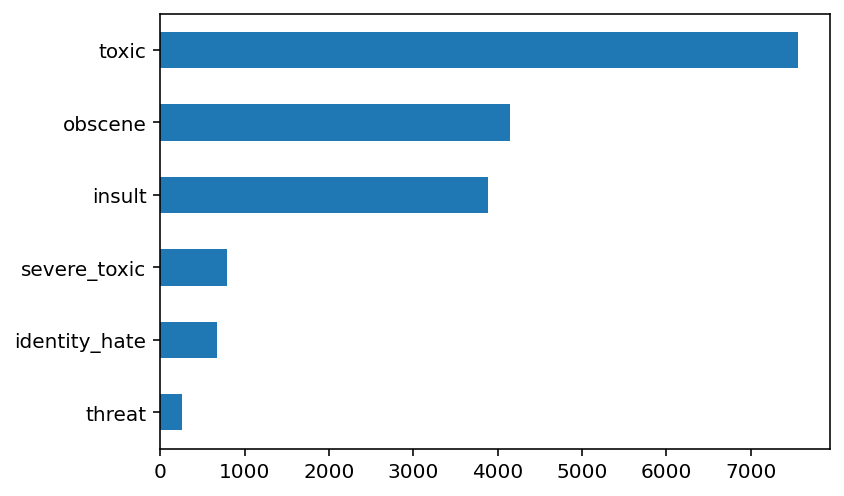

In [31]:
LABEL_COLUMNS = df.columns.tolist()[1:]
df[LABEL_COLUMNS].sum().sort_values().plot(kind="barh");

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


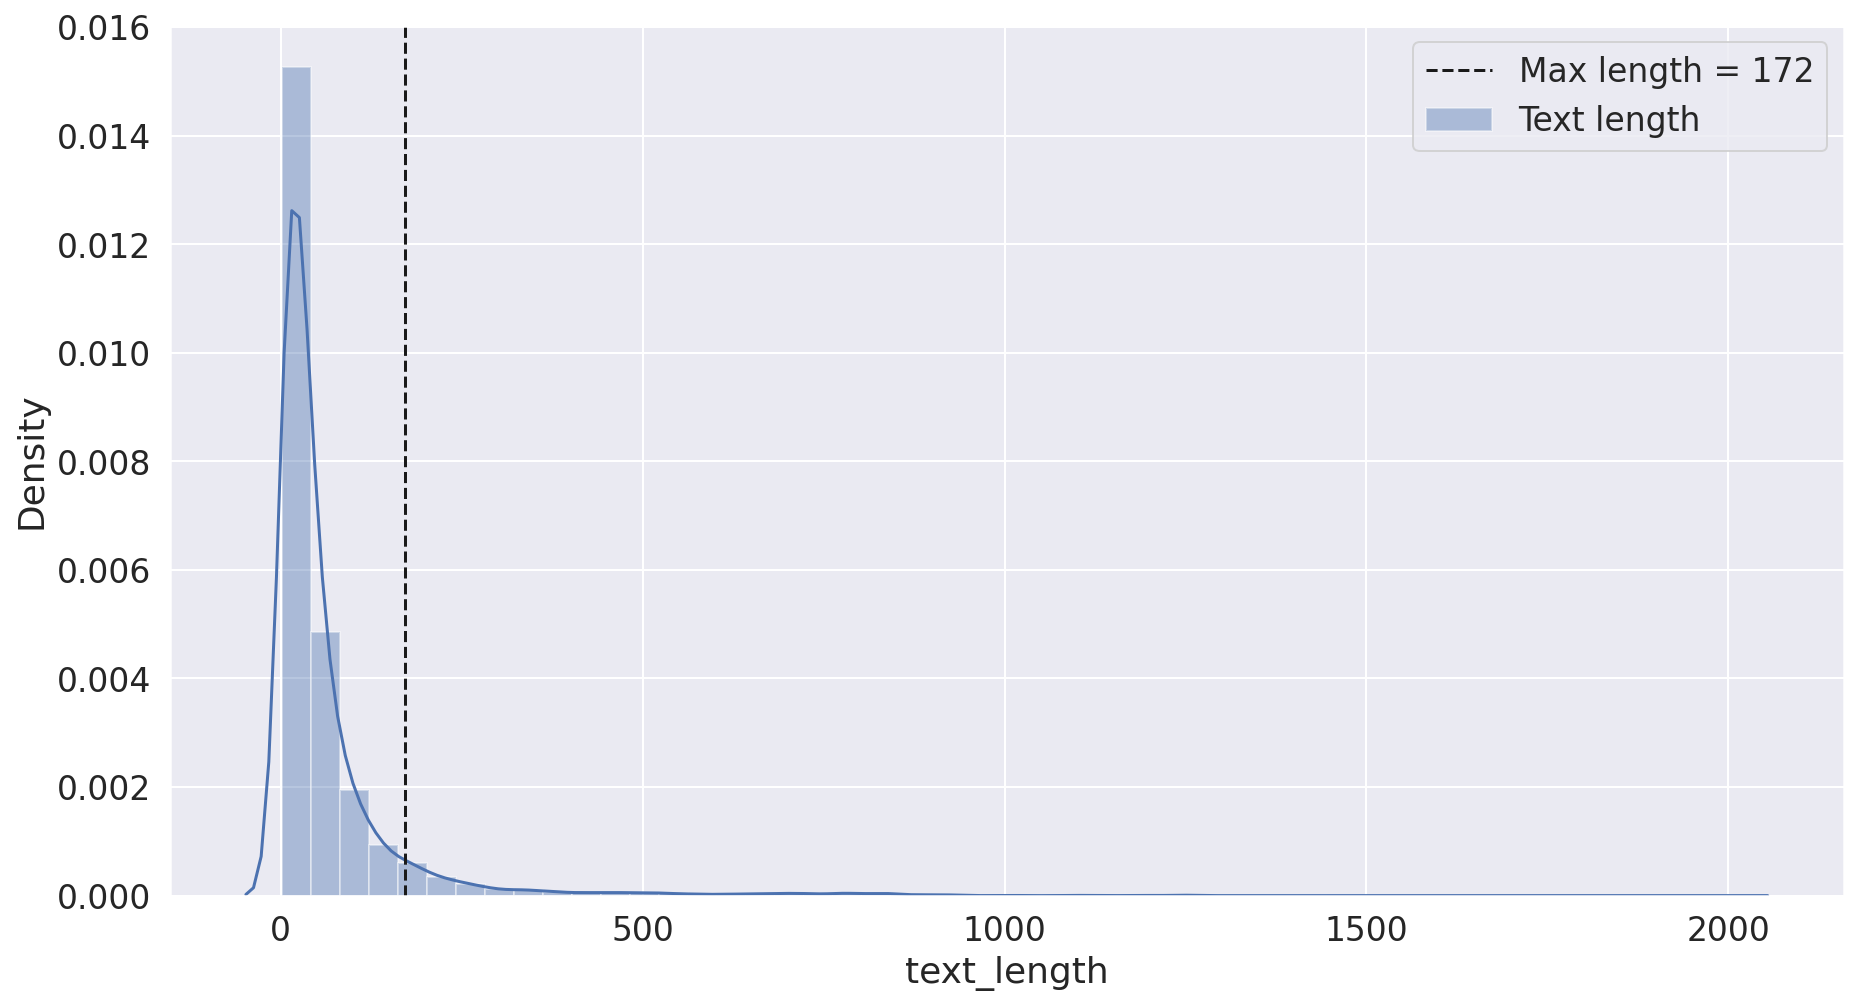

In [32]:
train["text_length"] = train["text"].apply(lambda words: len(words.split(" ")))
max_seq_len = np.round(train["text_length"].mean() + train["text_length"].std()).astype(int)

plt.figure(figsize=(15,8))
sns.set(font_scale = 1.5)
sns.distplot(train["text_length"], hist=True, kde=True, color='b', label='Text length')
label = 'Max length = {}'.format(max_seq_len)
plt.axvline(x=max_seq_len, color='k', linestyle='--', label=label)
plt.legend()
plt.show()

#free space
del train["text_length"]

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


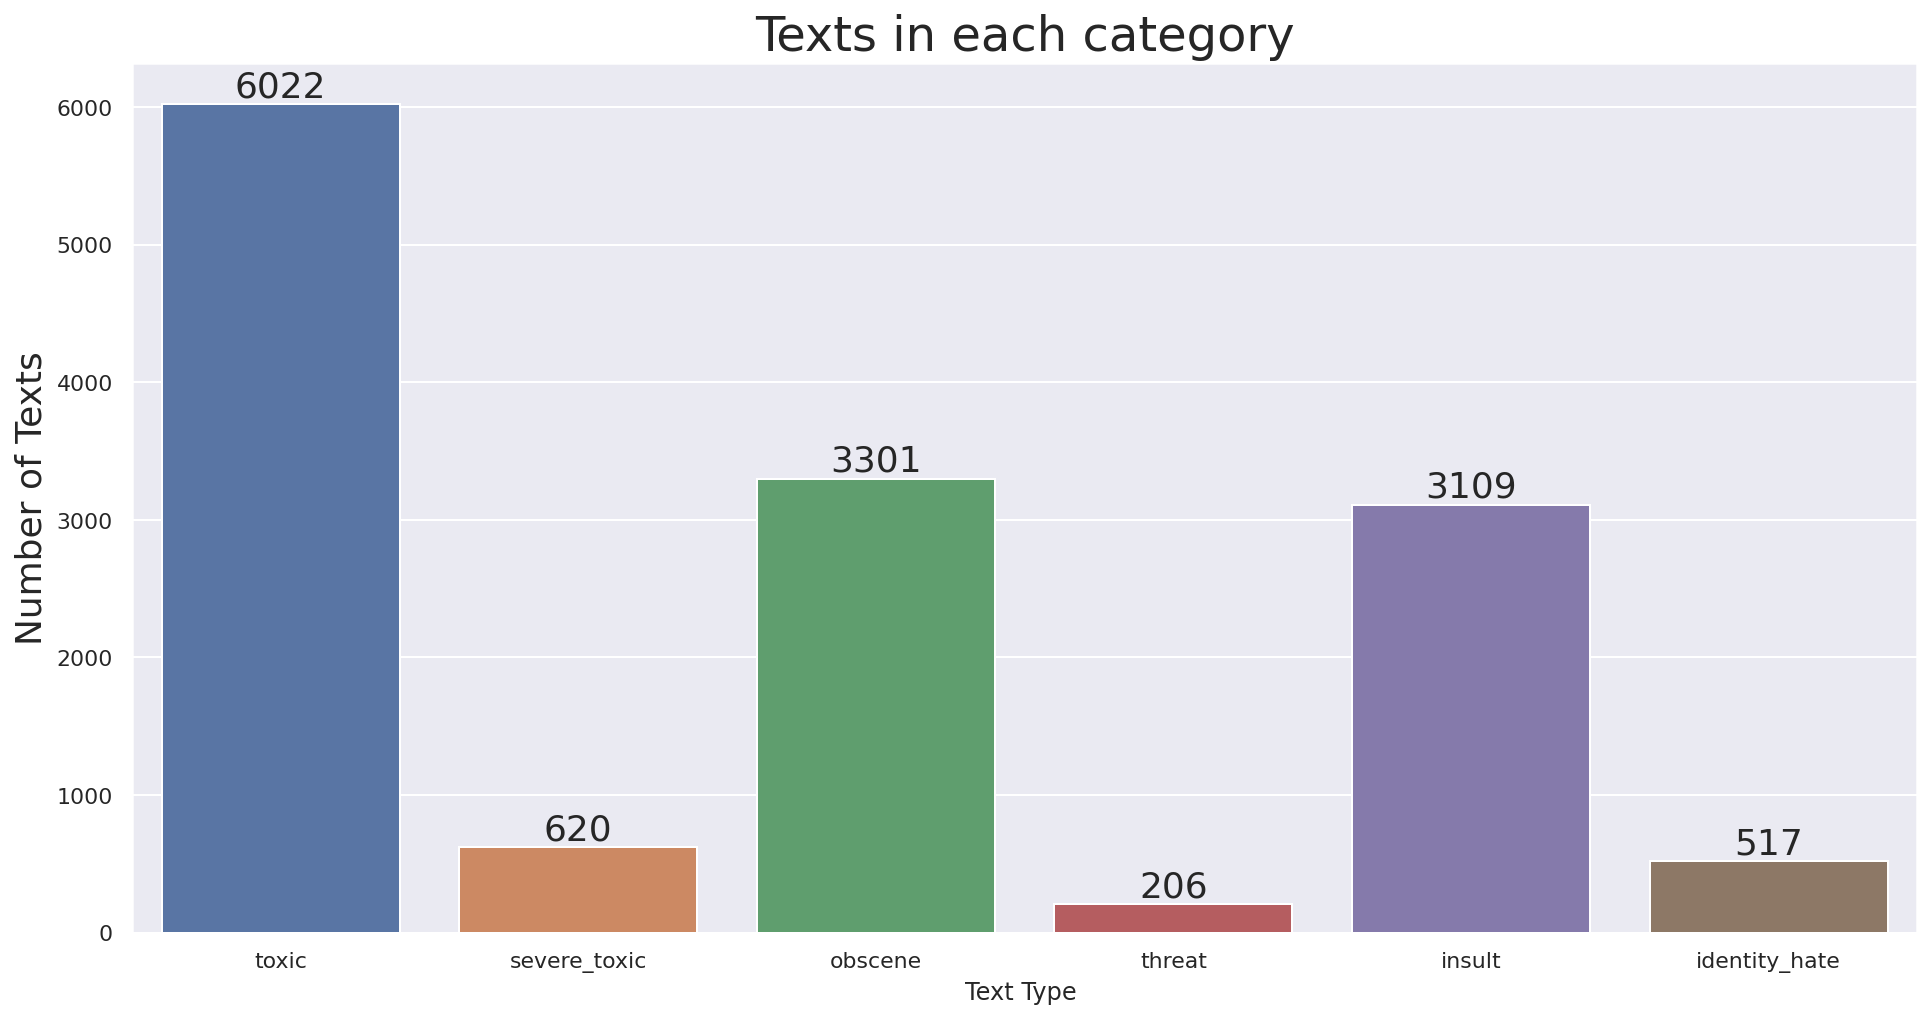

In [33]:
list_classes = list(train.columns[1:].values)
num_classes = len(list_classes)
y_train = train[list_classes].to_numpy()
distrib_classes = train[list_classes].sum(axis=0)

#visualize classes distribution
plt.figure(figsize=(16,8))
sns.set(font_scale = 1.0)
ax= sns.barplot(list_classes, distrib_classes)

plt.title("Texts in each category", fontsize=24)
plt.ylabel('Number of Texts', fontsize=18)
plt.xlabel('Text Type ', fontsize=12)

#add the count above:
rects = ax.patches
for rect, distrib_classe in zip(rects, distrib_classes):
    height = rect.get_height()
    ax.text(rect.get_x() + rect.get_width()/2, height + 5, distrib_classe, ha='center', va='bottom', fontsize=18)

plt.show()

In [34]:
# train_toxic = train[train[LABEL_COLUMNS].sum(axis=1) > 0]
# train_clean = train[train[LABEL_COLUMNS].sum(axis=1) == 0]

# pd.DataFrame(dict(
#   toxic=[len(train_toxic)], 
#   clean=[len(train_clean)]
# )).plot(kind='barh');

In [35]:
# train_clean

In [36]:

# train_df = pd.concat([
#   train_toxic,
#   train_clean.sample(3)
# ])

# train_df.shape, test.shape

In [37]:
# train_toxic = train[train[LABEL_COLUMNS].sum(axis=1) > 0]
# train_clean = train[train[LABEL_COLUMNS].sum(axis=1) == 0]

# pd.DataFrame(dict(
#   toxic=[len(train_toxic)], 
#   clean=[len(train_clean)]
# )).plot(kind='barh');

In [38]:
# !pip install pytorch_lightning

In [39]:
# !pip install transformers

In [40]:
# import pandas as pd
# import numpy as np

# from tqdm.auto import tqdm

# import torch
# import torch.nn as nn
# from torch.utils.data import Dataset, DataLoader

# from transformers import BertTokenizerFast as BertTokenizer, BertModel, AdamW, get_linear_schedule_with_warmup

# import pytorch_lightning as pl
# from torchmetrics.functional import accuracy, f1_score, auroc
# from pytorch_lightning.callbacks import ModelCheckpoint, EarlyStopping
# from pytorch_lightning.loggers import TensorBoardLogger

# from sklearn.model_selection import train_test_split
# from sklearn.metrics import classification_report, multilabel_confusion_matrix

# import seaborn as sns
# from pylab import rcParams
# import matplotlib.pyplot as plt
# from matplotlib import rc

# %matplotlib inline
# %config InlineBackend.figure_format='retina'

In [41]:
RANDOM_SEED = 42

sns.set(style='whitegrid', palette='muted', font_scale=1.2)
HAPPY_COLORS_PALETTE = ["#01BEFE", "#FFDD00", "#FF7D00", "#FF006D", "#ADFF02", "#8F00FF"]
sns.set_palette(sns.color_palette(HAPPY_COLORS_PALETTE))
rcParams['figure.figsize'] = 12, 8

pl.seed_everything(RANDOM_SEED)

Global seed set to 42


42

In [42]:
BERT_MODEL_NAME = 'bert-base-cased'
tokenizer = BertTokenizer.from_pretrained(BERT_MODEL_NAME)

Downloading:   0%|          | 0.00/29.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/208k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/426k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/570 [00:00<?, ?B/s]

In [43]:
sample_row = df.iloc[16]
sample_comment = sample_row.text
sample_labels = sample_row[LABEL_COLUMNS]

print(sample_comment)
print()
print(sample_labels.to_dict())

"

UNBLOCK ME OR I'LL GET MY LAWYERS ON TO YOU FOR BLOCKING MY CONSTITUTIONAL RIGHT TO FREE SPEECH"

{'toxic': 1, 'severe_toxic': 0, 'obscene': 0, 'threat': 0, 'insult': 0, 'identity_hate': 0}


In [44]:
encoding = tokenizer.encode_plus(
  sample_comment,
  add_special_tokens=True,
  max_length=60,
  return_token_type_ids=False,
  padding="max_length",
  return_attention_mask=True,
  return_tensors='pt',
)

encoding.keys()

dict_keys(['input_ids', 'attention_mask'])

In [45]:
encoding

{'input_ids': tensor([[  101,   107,  7414, 13360,  9244,  2428, 22157, 23066,   146,   112,
         12427, 25075,  1942,   150,  3663, 10722,  2924,  3663,  9637,  1708,
         21748, 16972, 19141,   143,  9565,   139,  2162,  9244,  2428, 15740,
           150,  3663, 18732, 12412, 21669, 27074, 21669, 11414, 12507,   155,
         23413, 18784, 16972,   143, 16941,  2036, 16625, 27073, 23258,   107,
           102,     0,     0,     0,     0,     0,     0,     0,     0,     0]]), 'attention_mask': tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
         1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
         1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0]])}

In [46]:
encoding["input_ids"].squeeze()

tensor([  101,   107,  7414, 13360,  9244,  2428, 22157, 23066,   146,   112,
        12427, 25075,  1942,   150,  3663, 10722,  2924,  3663,  9637,  1708,
        21748, 16972, 19141,   143,  9565,   139,  2162,  9244,  2428, 15740,
          150,  3663, 18732, 12412, 21669, 27074, 21669, 11414, 12507,   155,
        23413, 18784, 16972,   143, 16941,  2036, 16625, 27073, 23258,   107,
          102,     0,     0,     0,     0,     0,     0,     0,     0,     0])

In [47]:
encoding["attention_mask"].squeeze()

tensor([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0])

In [48]:
encoding["input_ids"].shape, encoding["attention_mask"].shape

(torch.Size([1, 60]), torch.Size([1, 60]))

In [49]:
print(tokenizer.convert_ids_to_tokens(encoding["input_ids"].squeeze()))

['[CLS]', '"', 'UN', '##BL', '##OC', '##K', 'ME', 'OR', 'I', "'", 'LL', 'GE', '##T', 'M', '##Y', 'LA', '##W', '##Y', '##ER', '##S', 'ON', 'TO', 'YOU', 'F', '##OR', 'B', '##L', '##OC', '##K', '##ING', 'M', '##Y', 'CO', '##NS', '##TI', '##TU', '##TI', '##ON', '##AL', 'R', '##IG', '##HT', 'TO', 'F', '##RE', '##E', 'SP', '##EE', '##CH', '"', '[SEP]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]']


In [50]:
token_counts = []

for _, row in train.iterrows():
  token_count = len(tokenizer.encode(
    row["text"], 
    max_length=512, 
    truncation=True
  ))
  token_counts.append(token_count)

(1.0, 512.0)

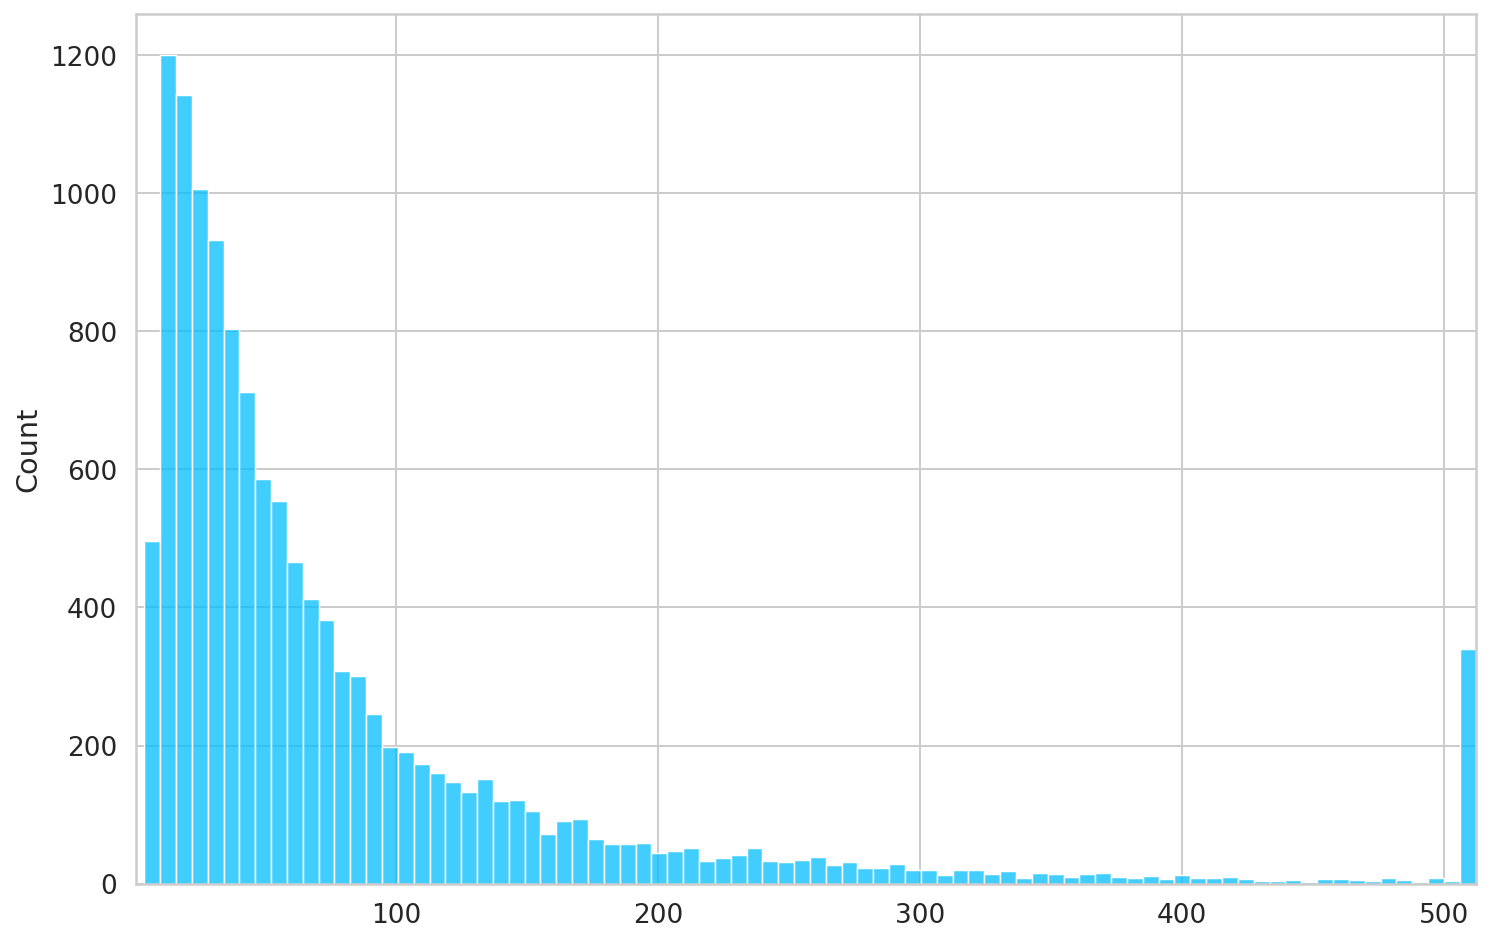

In [51]:
sns.histplot(token_counts)
plt.xlim([1,512])

In [52]:
MAX_TOKEN_COUNT = 100

In [53]:
class ToxicCommentsDataset(Dataset):

  def __init__(
    self, 
    data: pd.DataFrame, 
    tokenizer: BertTokenizer, 
    max_token_len: int = 128
  ):
    self.tokenizer = tokenizer
    self.data = data
    self.max_token_len = max_token_len
    
  def __len__(self):
    return len(self.data)

  def __getitem__(self, index: int):
    data_row = self.data.iloc[index]

    text = data_row.text
    labels = data_row[LABEL_COLUMNS]

    encoding = self.tokenizer.encode_plus(
      text,
      add_special_tokens=True,
      max_length=self.max_token_len,
      return_token_type_ids=False,
      padding="max_length",
      truncation=True,
      return_attention_mask=True,
      return_tensors='pt',
    )

    return dict(
      Text=text,
      input_ids=encoding["input_ids"].flatten(),
      attention_mask=encoding["attention_mask"].flatten(),
      labels=np.asarray(labels)
    )

In [54]:
train_dataset = ToxicCommentsDataset(
  train,
  tokenizer,
  max_token_len=MAX_TOKEN_COUNT
)

train_dataset[0]

{'Text': '"\n\nSorry, no?  ""No"" is what a master says to a dog.  ""No"" is what a parent says to a child.  Clearly you have this illusion that you\'re somehow more important than I am on wikipedia, that you are a boss of mine.  Since this illusion is likely the only thing keeping you from ending your sorry life, I will not end it for you.  I *am* your subordinate, and hopefully that makes up for your small penis.  Sorry, no?  Yes, master, anything you say.  You have power over me.  I must repent!       talk #c "',
 'attention_mask': tensor([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
         1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
         1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
         1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
         1, 1, 1, 1]),
 'input_ids': tensor([  101,   107,  6502,   117,  1185,   136,   107,   107,  1302,   107,
           107,  1110

In [55]:
test_dataset=ToxicCommentsDataset(
    test,
    tokenizer,
    max_token_len=MAX_TOKEN_COUNT
)
test_dataset[0]

{'Text': '"\nI do not see any anti-semitism here. If the guy gives lectures in New York synagogues and knocks down his country every single minute, using every opportunity in such influential newspapers as New York Post, then one can state that his interests are not only personal. You can not find any intellectual person among neoconservatives in New York Post. Michelle Malkin, Andrea Peyser, Deborah Orin (may her rest in peace, although I know she is rotting in hell)and other essayists are the ones who make a great company for Amir Taheri. This guy has no mind at all. I agree that Iran\'s regime is wrong, but the regime of Shah that Amir Taheri is longing for, because he owned Keyhan during that regime was not any better and Islamic Revolution was justified. Look at how they intriduce Amir Taheri in both this article and in New York Post. ""Based in Europe memeber of Benador Associates"". Is Europe that small? Is that a small town? Why don\'t they say based in the world journalist. Or

In [56]:
train_dataset[0]['labels']

array([1, 0, 0, 0, 0, 0], dtype=object)

In [57]:
train_input_id_tensors,train_attention_mask_tensor,y_train=[],[],[]
for ind in range(len(train)):
  sample_data=train_dataset[ind]
  train_input_id_tensors.append(sample_data['input_ids'])
  train_attention_mask_tensor.append(sample_data['attention_mask'])
  y_train.append(sample_data['labels'])
  # print(ind)
  # print('Input Id: ',sample_data['input_ids'])
  # print('Attentionmask: ',sample_data['attention_mask'])
  # print('\n====================================\n')
train_input_id_tensors = torch.Tensor([t.size() for t in train_input_id_tensors]).to(torch.int64)
train_attention_mask_tensor=torch.Tensor([t.size() for t in train_attention_mask_tensor]).to(torch.int64)
# y_train=torch.Tensor([t.size() for t in y_train]).to(torch.int64)

In [58]:
test_input_id_tensors,test_attention_mask_tensor,y_test=[],[],[]
for ind in range(len(test)):
  sample_data=test_dataset[ind]
  test_input_id_tensors.append(sample_data['input_ids'])
  test_attention_mask_tensor.append(sample_data['attention_mask'])
  y_test.append(sample_data['labels'])
  # print(ind)
  # print('Input Id: ',sample_data['input_ids'])
  # print('Attentionmask: ',sample_data['attention_mask'])
  # print('\n====================================\n')
test_input_id_tensors = torch.Tensor([t.size() for t in test_input_id_tensors]).to(torch.int64)
test_attention_mask_tensor=torch.Tensor([t.size() for t in test_attention_mask_tensor]).to(torch.int64)
# y_test=torch.Tensor([t.size() for t in y_test]).to(torch.int64)

In [59]:
y_train[:5]

[array([1, 0, 0, 0, 0, 0], dtype=object),
 array([0, 0, 0, 0, 0, 0], dtype=object),
 array([0, 0, 0, 0, 0, 0], dtype=object),
 array([0, 0, 0, 0, 0, 0], dtype=object),
 array([0, 0, 0, 0, 0, 0], dtype=object)]

In [60]:
# import tensorflow as tf

In [61]:
# type(train_input_id_tensors)

In [62]:
# import torch

In [63]:
# input_id_tensors = torch.Tensor([t.size() for t in input_id_tensors]).to(torch.int64)
# attention_mask_tensor=torch.Tensor([t.size() for t in attention_mask_tensor]).to(torch.int64)


In [64]:
bert_model = BertModel.from_pretrained(BERT_MODEL_NAME, return_dict=True)

Downloading:   0%|          | 0.00/416M [00:00<?, ?B/s]

Some weights of the model checkpoint at bert-base-cased were not used when initializing BertModel: ['cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.bias', 'cls.predictions.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [65]:
# input_id_tensors.shape,attention_mask_tensor.shape

In [66]:
# type(input_id_tensors)

In [67]:
# sample_batch = next(iter(DataLoader(train_dataset, batch_size=10, num_workers=2)))
# sample_batch["input_ids"].shape, sample_batch["attention_mask"].shape

In [68]:
x_train = bert_model(train_input_id_tensors, train_attention_mask_tensor)

In [69]:
x_test = bert_model(test_input_id_tensors, test_attention_mask_tensor)

In [70]:

x_train=x_train[0][:,0,:].detach().numpy().astype('float32')
x_test=x_test[0][:,0,:].detach().numpy().astype('float32')
y_train=np.asarray(y_train).astype('float32')
y_test=np.asarray(y_test).astype('float32')

In [71]:
x_train[:5]

array([[ 0.04111378, -0.3533376 ,  0.27209476, ..., -0.07853311,
         0.00537459,  0.7833747 ],
       [ 0.04111378, -0.3533376 ,  0.27209476, ..., -0.07853311,
         0.00537459,  0.7833747 ],
       [ 0.04111378, -0.3533376 ,  0.27209476, ..., -0.07853311,
         0.00537459,  0.7833747 ],
       [ 0.04111378, -0.3533376 ,  0.27209476, ..., -0.07853311,
         0.00537459,  0.7833747 ],
       [ 0.04111378, -0.3533376 ,  0.27209476, ..., -0.07853311,
         0.00537459,  0.7833747 ]], dtype=float32)

In [72]:
y_train[:5]

array([[1., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0.]], dtype=float32)

In [73]:
x_train.shape

(12800, 768)

In [74]:
type(x_train)

numpy.ndarray

In [75]:
y_train.shape

(12800, 6)

In [76]:
type(y_train)

numpy.ndarray

In [77]:
x_test.shape

(3200, 768)

In [78]:
type(x_test)

numpy.ndarray

In [79]:
y_test.shape

(3200, 6)

In [80]:
type(y_test)

numpy.ndarray

In [81]:
x_train=np.reshape(x_train,(12800,-1,768))
x_test=np.reshape(x_test,(3200,-1,768))

In [82]:
# x_train[0].shape

In [83]:
# x_train[0][0].shape

In [84]:
# type(x_train[0])

In [85]:
# x_train.last_hidden_state.shape, x_train.pooler_output.shape

In [86]:
# x_test[0]

In [87]:
# y_train=np.asarray(y_train)
# y_test=np.asarray(y_test)
# y_train = tf.convert_to_tensor(y_train)
# y_test=tf.convert_to_tensor(y_test)

In [88]:
# y_train

In [89]:
# type(y_train)

In [90]:
# x_test[0]

In [91]:
# type(x_test)

In [92]:
# x_test.last_hidden_state.shape, x_test.pooler_output.shape

In [93]:
# y_train.shape

In [94]:
# y_test.shape

In [95]:
bert_model.config.hidden_size

768

In [96]:
# df.head()

In [97]:
# pip install scikit-multilearn

In [98]:
# lengthed=[]
# for i in df['text']:
#   lengthed.append(len(i.split(" ")))

# print(max(lengthed))


In [99]:
# len(df['text'][0].split(' '))

In [100]:
import numpy as np
from keras.preprocessing import sequence
from keras.models import Sequential
from keras.layers import Dense, Dropout, Embedding, LSTM, Bidirectional

In [101]:
model = Sequential()
model.add(LSTM(256,input_dim=768,activation='relu'))
model.add(Dense(128,activation='relu'))
model.add(Dense(64, activation='relu'))
model.add(Dense(6, activation='sigmoid'))



In [102]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 256)               1049600   
                                                                 
 dense (Dense)               (None, 128)               32896     
                                                                 
 dense_1 (Dense)             (None, 64)                8256      
                                                                 
 dense_2 (Dense)             (None, 6)                 390       
                                                                 
Total params: 1,091,142
Trainable params: 1,091,142
Non-trainable params: 0
_________________________________________________________________


In [103]:
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])


In [104]:
model.fit(x_train,y_train,epochs=10,validation_data=(x_test,y_test))

Epoch 1/10
400/400 [==============================] - 6s 7ms/step - loss: 7.2433 - accuracy: 0.5943 - val_loss: 18.7036 - val_accuracy: 0.0159
Epoch 2/10
400/400 [==============================] - 3s 8ms/step - loss: 185.5737 - accuracy: 0.4436 - val_loss: 327.5692 - val_accuracy: 0.9731
Epoch 3/10
400/400 [==============================] - 2s 5ms/step - loss: 708.4815 - accuracy: 0.4427 - val_loss: 1446.2972 - val_accuracy: 0.0159
Epoch 4/10
400/400 [==============================] - 2s 4ms/step - loss: 2410.4155 - accuracy: 0.4383 - val_loss: 2766.4741 - val_accuracy: 0.9731
Epoch 5/10
400/400 [==============================] - 2s 4ms/step - loss: 4940.5381 - accuracy: 0.4439 - val_loss: 5385.2192 - val_accuracy: 0.0091
Epoch 6/10
400/400 [==============================] - 2s 4ms/step - loss: 8708.2949 - accuracy: 0.4445 - val_loss: 11186.5977 - val_accuracy: 0.9731
Epoch 7/10
400/400 [==============================] - 2s 4ms/step - loss: 15321.6055 - accuracy: 0.4371 - val_loss: 118